In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
import pickle
import matplotlib.pyplot as plt

In [4]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
#read in new_data
data_path = '/Users/Dom/Desktop/Hackaton_Code/new_covid.csv'
data_path = "/content/drive/MyDrive/Hackaton_GSG/new data/new_covid.csv"
clean_data = np.array(pd.read_csv(data_path, delimiter = ',',encoding = 'cp1252'))[:,1:]

In [24]:
#crate a validation set
zero_data =  clean_data[np.where(clean_data[:,-1] == 0)]
one_data = clean_data[np.where(clean_data[:,-1] == 1)]
np.random.shuffle(zero_data)
np.random.shuffle(one_data) 
validation = np.append(zero_data[0:500,:],one_data[0:500,:],0)
test_train = np.append(zero_data[500:,:],one_data[500:,:],0)

In [ ]:
#trying to find number of NB models to use
all_acc = []
for i in range(10):
    mod_types = ['NB']
    models,col_names = generate_models(50,mod_types,test_train)
    X_test = create_test_matrix(validation,col_names,400,full = True)
    acc  = np.zeros((len(models),2))
    for i in range(len(models)):
        acc[i,0] = get_adv_acc(models[0:i+1],X_test[:,:-1],X_test[:,-1])
        acc[i,1] = i+1
    all_acc.append(acc)

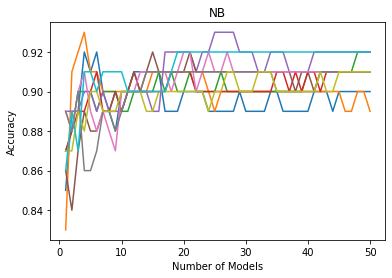

In [ ]:
for i in range(len(all_acc)):
    plt.plot(all_acc[i][:,1],all_acc[i][:,0]);
    plt.title('NB')
    plt.ylabel('Accuracy')
    plt.xlabel('Number of Models')

In [ ]:
#trying to find the number of logistic models to use
all_acc = []
for i in range(10):
    mod_types = ['Log']
    models,col_names = generate_models(50,mod_types,test_train)
    X_test = create_test_matrix(validation,col_names,400,full = True)
    acc  = np.zeros((len(models),2))
    for i in range(len(models)):
        acc[i,0] = get_adv_acc(models[0:i+1],X_test[:,:-1],X_test[:,-1])
        acc[i,1] = i+1
    all_acc.append(acc)

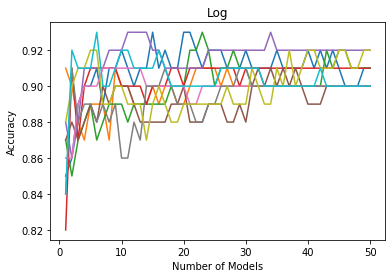

In [ ]:
for i in range(len(all_acc)):
    plt.plot(all_acc[i][:,1],all_acc[i][:,0]);
    plt.title('Log')
    plt.ylabel('Accuracy')
    plt.xlabel('Number of Models')

In [9]:
number = [25,35,1]
mod_types = ['NB','Log','RF']
models,col_names = generate_models(number,mod_types,test_train)

In [10]:
X_test = create_test_matrix(validation,col_names,400,full = True)

In [11]:
#nb acc
get_adv_acc(models[0:25],X_test[:,:-1],X_test[:,-1])

0.914

In [12]:
#log
get_adv_acc(models[25:60],X_test[:,:-1],X_test[:,-1])

0.937

In [13]:
#nb and log acc
get_adv_acc(models[0:-1],X_test[:,:-1],X_test[:,-1])

0.941

In [ ]:
#playing and testing model with setences 
s1 = ['covid spreads very easily from person to person']
s2 = ['covid19 is real']
s3 = ['old people are at a higher risk of  getting covid19']
s4 = ['COIVD19 from close contact']
row = get_row(s3,col_names)
get_prediction(models,row)

[[0.28834356 0.71165644]]


True

In [17]:
#saving model
#save_path = '/Users/Dom/Desktop/Hackaton_Code/model_final_2.pkl'
save_path = "/content/drive/MyDrive/Hackaton_GSG/final_model_2.pkl"
with open(save_path,'wb') as f:
    pickle.dump([models,col_names],f)

In [ ]:
#FUNCTIONS

In [8]:
def get_adv_acc(models,data_test,class_val,get_f1 = False):
#gets the adv_acc for 'n' models
#Inputs
#models - list of all models
#data_test - test data
#class_val - class value of test data
#get_f1 - return f1 score or accuracy 
    prob = np.zeros((len(data_test),2))
    
    for m in (models):
        prediciton = m.predict_proba(data_test)
        prob = prob + prediciton
 
    prob = np.divide(prob,len(models))
 
    prob[np.where(prob[:,0] > prob[:,1])] = 0
    #prob[np.where(prob[:,1] > prob[:,0])] = 1 #this way works
    prob[np.where(prob[:,0] != prob [:,1])] = 1 #or this way also a check

    class_val = np.reshape(class_val,(len(class_val),1))
    prob_a_class = np.append(prob,class_val,1)

    right = len(prob_a_class[np.where(prob_a_class[:,0]== prob_a_class[:,2])])

    percent_right = right/len(class_val)
    f1 = f1_score(prob_a_class[:,0],prob_a_class[:,2])
    
    if(get_f1 == True):
        return f1
    
    if(get_f1 == False):
        return percent_right

def generate_models(number,model_type,clean_data):
    models = []
    zero_data,one_data,col_names = create_BOW(clean_data)
    if('NB' in model_type):
        for i in range(number[0]):
            X_train = shuffle_split_train(zero_data,one_data)
            model_i = MultinomialNB()
            model_i.fit(X_train[:,:-1], X_train[:,-1])
            models.append(model_i)
    if('Log' in model_type):
        for i in range(number[1]):
            X_train = shuffle_split_train(zero_data,one_data)
            model_i = LogisticRegression(random_state=0,solver = 'lbfgs')
            model_i.fit(X_train[:,:-1], X_train[:,-1])
            models.append(model_i)
    if('RF' in model_type):
        for i in range(number[2]):
            X_train = shuffle_split_train(zero_data,one_data)
            model_i = RandomForestClassifier(n_estimators = 100,random_state=0)
            model_i.fit(X_train[:,:-1], X_train[:,-1])
            models.append(model_i)
    return models,col_names

def create_BOW (clean_data,stop_words = True):
    if(stop_words == True):
        vectorizer = CountVectorizer(stop_words = 'english')
    elif(stop_words == False):
        vectorizer = CountVectorizer()
    data_matrix = vectorizer.fit_transform(clean_data[:,0])
    data = np.append(data_matrix.toarray(),np.reshape(clean_data[:,1],(len(clean_data),1)),1)
    zero_data =  data[np.where(data[:,-1] == 0)]
    one_data = data[np.where(data[:,-1] == 1)]
    col_names = vectorizer.get_feature_names()
    return zero_data,one_data,col_names

def shuffle_split_train(zero_data,one_data):
  #shuffle and split data into train
    np.random.shuffle(zero_data)
    zero_train = zero_data[0:3000,:]
    np.random.shuffle(one_data)
    one_train = one_data[0:3000,:]
    X_train = np.uint64(np.append(zero_train,one_train,0))
    return X_train

def create_test_matrix(clean_data,col_names,count,full = False,stop_words = True):
    if(stop_words == True):
        vectorizer = CountVectorizer(stop_words = 'english',vocabulary = col_names)
    elif(stop_words == False):
        vectorizer = CountVectorizer(vocabulary = col_names)
    data_matrix = vectorizer.fit_transform(clean_data[:,0])
    data = np.append(data_matrix.toarray(),np.reshape(clean_data[:,1],(len(clean_data),1)),1)
    zero_data =  data[np.where(data[:,-1] == 0)]
    one_data = data[np.where(data[:,-1] == 1)]
    np.random.shuffle(zero_data)
    np.random.shuffle(one_data)
    if(full == False):
        zero_test = zero_data[0:count,:]
        one_test = one_data[0:count,:]
    if(full == True):
        zero_test = zero_data
        one_test = one_data
    X_test = np.uint64(np.append(zero_test,one_test,0))
    return X_test

def get_row(sentence,col_names,stop_words = True):
    if(stop_words == True):
        vectorizer = CountVectorizer(stop_words = 'english',vocabulary = col_names)
    elif(stop_words == False):
        vectorizer = CountVectorizer(vocabulary = col_names)
    row = vectorizer.fit_transform(sentence)
    return row

def get_prediction(models,row):
    prob = np.zeros((1,2))
    
    for m in (models):
        prediciton = m.predict_proba(row)
        prob = prob + prediciton
    prob = np.divide(prob,len(models))
    
    print(prob)
    if(prob[0,0] > prob[0,1]):
        return False
    if(prob[0,1] > prob[0,0]):
        return True